In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow as tf
from tensorflow.python import keras
import warnings 
import argparse
warnings.filterwarnings('ignore')
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras import Input, Model
from keras.applications import MobileNet
from keras.layers.core import Flatten, Dense,Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score
import numpy
import sklearn.metrics as metrics

cropName="All_Crops"
basepath="/content/drive/MyDrive/Colab_Notebooks/Early_Detection_Of_Crop_Diseases"
# set base directory
base_dir = basepath+'/dataset/'+cropName
print(os.listdir(base_dir))
print(len(os.listdir(os.path.join(base_dir, 'train'))))

# Data Augmentation transformations for the train dataset
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,fill_mode='nearest')

# Data augmentation for validation dataset
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Data augmentation for testing dataset
# testing_datagen = ImageDataGenerator(rescale = 1./255)

# Loading the images from their directories
BATCH_SIZE = 32
train_set_from_dir = train_datagen.flow_from_directory(os.path.join(base_dir, 'train'),target_size = (224,224),batch_size = BATCH_SIZE,class_mode = 'categorical')
validation_set_from_dir = validation_datagen.flow_from_directory(os.path.join(base_dir, 'test'),target_size = (224,224),batch_size = BATCH_SIZE,class_mode = 'categorical')
# testing_set_from_dir = testing_datagen.flow_from_directory(os.path.join(base_dir, 'test'),target_size = (224,224),batch_size = BATCH_SIZE,class_mode = 'categorical')

# dictionary of classes
classes_dict = train_set_from_dir.class_indices

# storing classes dict in json file
import json
if not os.path.isdir(basepath+'/Results/'+cropName):
    os.mkdir(basepath+'/Results/'+cropName)
with open(basepath+'/Results/'+cropName+'/class_indices.json','w') as f:
    json.dump(classes_dict, f)

['test', 'train']
38
Found 43461 images belonging to 38 classes.
Found 10857 images belonging to 38 classes.


In [2]:
# Transfer learning with MobileNet architecture
base_model = MobileNet(weights="imagenet",input_shape=(224, 224, 3),include_top=False)
# print(base_model.summary())
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dropout(0.2)(head_model)
outputs = Dense(38, activation="softmax")(head_model)
mobilenet_model = Model(base_model.input, outputs, name='pretrained_mobilenet' )
for layer in mobilenet_model.layers:
    layer.trainable = False
for layer in base_model.layers[:20]:
    layer.trainable=False
for layer in base_model.layers[20:]:
    layer.trainable=True
    
# Compiling the model with the optimizer and loss function 
mobilenet_model.compile(optimizer = Adam(),loss = 'categorical_crossentropy',metrics = ['accuracy'])
# print(mobilenet_model.summary())
# for idx, layer in enumerate(mobilenet_model.layers):
#     print(idx, layer.name, layer.trainable)
print("Done")

17227776/17225924 [==============================] - 1s 0us/step
Done


In [3]:
# Setting up callbacks for our model
if not os.path.isdir(basepath+'/Results/'+cropName+'/checkpoints'):
    os.mkdir(basepath+'/Results/'+cropName+'/checkpoints')
callbacks = [ModelCheckpoint(basepath+'/Results/'+cropName+'/checkpoints/mobilenet_plantdiseases.h5', save_best_only=True, monitor='val_accuracy'),EarlyStopping(monitor='val_loss', patience=2, verbose=1),ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1)]
N_EPOCHS = 10
history = mobilenet_model.fit(train_set_from_dir,
          validation_data = validation_set_from_dir,
          epochs = N_EPOCHS,
          # Use 256 random batches for training set 
          steps_per_epoch = 256, # 256 x 32 random samples
          # Use 64 random batches for training validation set
          validation_steps = 200, # 200 x 32 random samples 
          callbacks = callbacks
)

Epoch 1/10
256/256 [==============================] - 6986s 27s/step - loss: 1.0341 - accuracy: 0.7341 - val_loss: 1.1799 - val_accuracy: 0.6931
Epoch 2/10
256/256 [==============================] - 4502s 18s/step - loss: 0.2897 - accuracy: 0.9138 - val_loss: 0.2860 - val_accuracy: 0.9095
Epoch 3/10
256/256 [==============================] - 3203s 13s/step - loss: 0.2207 - accuracy: 0.9322 - val_loss: 0.4487 - val_accuracy: 0.8816
Epoch 4/10
256/256 [==============================] - 2432s 9s/step - loss: 0.1333 - accuracy: 0.9581 - val_loss: 0.3780 - val_accuracy: 0.8972
Epoch 00004: early stopping


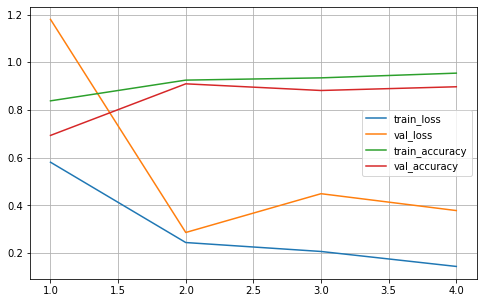

In [4]:
# plot performance graph
n = 4
plt.figure(figsize = (8,5))
plt.plot(np.arange(1,n+1), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(1,n+1), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(1,n+1), history.history['accuracy'], label = 'train_accuracy')
plt.plot(np.arange(1,n+1), history.history['val_accuracy'], label = 'val_accuracy')
plt.grid(True)
plt.legend(loc = "best")
plt.savefig(basepath+'/Results/'+cropName+'/performance.jpg')
plt.show()

In [5]:
# Evaluate the model on the validation dataset
results = mobilenet_model.evaluate(validation_set_from_dir)
print("Loss:", results[0])
print("Accuracy:", results[1])
print(results)

340/340 [==============================] - 190s 561ms/step - loss: 0.3805 - accuracy: 0.8975
Loss: 0.3805152475833893
Accuracy: 0.8974854946136475
[0.3805152475833893, 0.8974854946136475]


In [11]:
# # Testing on a random image from the test images directory
from PIL import Image
test1 = Image.open("/content/drive/MyDrive/Colab_Notebooks/Early_Detection_Of_Crop_Diseases/dataset/All_Crops/test/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/0a01cc10-3892-4311-9c48-0ac6ab3c7c43___RS_GLSp 9352.JPG")
test1 = test1.resize((224,224))
test1_scaled = np.expand_dims(np.asarray(test1), axis = 0) / 255
predictions = mobilenet_model.predict(test1_scaled)
print(predictions)
classes_dict = train_set_from_dir.class_indices
classes_dict = { v:k for (k,v) in classes_dict.items() }
print("Disease: "+classes_dict[np.argmax(predictions)])

[[6.66405598e-04 4.93915868e-04 5.47046482e-04 1.34531455e-03
  3.57063524e-02 4.89848142e-04 8.59954208e-03 7.42013693e-01
  2.33879518e-02 6.83550090e-02 5.11985272e-02 1.07205729e-03
  1.52175524e-03 2.62830545e-05 4.60701878e-04 1.50704145e-04
  5.40333203e-05 8.31003184e-04 7.86985562e-04 3.25671141e-03
  5.38356835e-04 5.89804695e-05 3.20140942e-04 1.97494356e-03
  2.76212158e-05 1.17472429e-02 1.69781235e-03 6.78348541e-03
  2.50810245e-03 1.04488114e-04 4.09364840e-03 4.13841428e-03
  2.29966175e-03 2.14303518e-03 5.50884986e-04 1.62677537e-03
  1.30295530e-02 5.39304642e-03]]
Disease: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


In [9]:
# save the model
mobilenet_model.save(basepath+'/Results/'+cropName+'/mobilenet_model.h5')